# TensorFlow Natural Language Processing Guide

**In this notebook I will demonstrate how to process natural language and predict sentiment in TensorFlow.**

-------------------------------------------------------------------------
**Notebook Prerequisites:**
- Python                               > https://www.kaggle.com/learn/python
- Data Visualization with Matplotlib   > https://www.kaggle.com/learn/data-visualization
- Basic Linear Algebra                 > https://www.youtube.com/watch?v=fNk_zzaMoSs&list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab
- Basic Knowledge of Machine Learning  > https://www.kaggle.com/learn/intro-to-machine-learning


---------------------------------------------------------------------------------------------------

**This notebook will cover the following topics:**
- Loading datasets from the Tensorflow Datasets API
- Tokenizing text data into a numerical representation
- Creating sequences (with padding) out of tokenized data
- Creating a sequence-aware LSTM model with text embedding
- Using custom and premade callbacks
- Evaluating a models performance


*Note: You should research anything in this notebook that you do not understand. Some links will be provided*

# Load IMDB Dataset

We will load the `imdb_reviews` dataset from TensorFlow datasets API. This dataset contains 50,000 movie reviews that are categorized as either positive (1) or negative (0). We will extract just the first 20 words from each review to speed up training.

Link: https://www.tensorflow.org/datasets/catalog/imdb_reviews

In [1]:
#Import libraries
import tensorflow as tf #TensorFlow
import tensorflow_datasets as tfds #Datasets
import numpy as np #linear algebra
import matplotlib.pyplot as plt #Data visualization

#Make sure TensorFlow is version 2.0 or higher
print('TensorFlow Version:', tf.__version__)

TensorFlow Version: 2.6.2


In [2]:
#Download dataset
#dataset documentation -> https://www.tensorflow.org/datasets/catalog/imdb_reviews
text_data = tfds.load('imdb_reviews', split=['train', 'test']) 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling imdb_reviews-train.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling imdb_reviews-test.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling imdb_reviews-unsupervised.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
#Create empty lists to hold our training and test text and labels
train_text = []
train_labels = []
test_text = []
test_labels = []

#Iterate over the imdb data set and add text + labels to their respective list variables
for row in text_data[0]: #training set
    #takes just the first 20 words from the review
    train_text.append(row['text'].numpy().decode('utf-8').split()[:20]) 
    train_labels.append(row['label'].numpy())
    
for row in text_data[1]: #testing set
    #takes just the first 20 words from the review
    test_text.append(row['text'].numpy().decode('utf-8').split()[:20]) 
    test_labels.append(row['label'].numpy())
    

#prints a samples from the training set
print("FIRST 5 SAMPLES OF TRAINING DATA")
print("============================================================")
for i in range(5):
    review = "POSITIVE" if train_labels[i] == 1 else "NEGATIVE"
    print("REVIEW SENTIMENT:", review)
    print("REVIEW TEXT:", " ".join(train_text[i]))
    print("============================================================")

FIRST 5 SAMPLES OF TRAINING DATA
REVIEW SENTIMENT: NEGATIVE
REVIEW TEXT: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors,
REVIEW SENTIMENT: NEGATIVE
REVIEW TEXT: I have been known to fall asleep during films, but this is usually due to a combination of things including,
REVIEW SENTIMENT: NEGATIVE
REVIEW TEXT: Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as
REVIEW SENTIMENT: POSITIVE
REVIEW TEXT: This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead
REVIEW SENTIMENT: POSITIVE
REVIEW TEXT: As others have mentioned, all the women that go nude in this film are mostly absolutely gorgeous. The plot very


# Transform Text into Numerical Representation

Words have meaning to us but computers can only understand numbers. Because of this, we must somehow transform the words into a numerical representation. The TensorFlow `Tokenizer` class can do just that. The `Tokenizer` maps each new word it encounters (limited by the `num_words` attribute) to an number. From here, the numeric representations need to be padded with the `pad_sequences` function so that all inputs to the future model will be of equal length.

Links: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
       https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Creates and fits a TensorFlow Tokenizer
tokenizer = Tokenizer(num_words=10_000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_text)

#Creates sequences of numeric representations of words
training_sequences = tokenizer.texts_to_sequences(train_text)
#pads sequences so they all have the same length
training_sequences = pad_sequences(training_sequences, maxlen=20)

#Process test data in the same way for later evaluation
testing_sequences = tokenizer.texts_to_sequences(test_text)
testing_sequences = pad_sequences(testing_sequences, maxlen=20)

        
#prints a sample of the new sequences
print('PROCESSED TEXT DATA')
print('=========================')
for i in range(5):
    print(training_sequences[i], '\n')

PROCESSED TEXT DATA
[   5   13   24  202  329   66   83   27 6022   10   31 1117 4618   65
  370    1  259   33   59  909] 

[   4   20   57  507    9 1118 2953  295  387   22    5    8  364  650
    9    3 1297    6  252    1] 

[2350 7150    2    1 5215 6023   10    3  799    1    7 2023 1202    7
 1556 7151  218  625  516   17] 

[   5    8    2  285    6   15   16    3 3711 1203 1677   36    2 1144
    6    2  230   64  178 2482] 

[  17  571   20 4126   40    2  517   14  178 4127   10    5   15   33
  983  202 6024    2  117   42] 



# Custom Callback

Callbacks are used in Tensorflow to allow user intervention during model training. A callback can be executed at a number of specific intances during model training. 
For example: 
- `on_batch_begin`/`end`
- `on_epoch_begin`/`end`
- `on_predict_batch_begin`/`end`
- `on_predict_begin`/`end`
- `on_test_batch_begin`/`end`
- `on_test_begin`/`end`
- `on_train_batch_begin`/`end`
- `on_train_begin`/`end`

We will create `CustomCallback` which will stop the model from training once the model reaches 95% acccuracy on the training set.

Link: https://keras.io/api/callbacks/

In [5]:
from tensorflow.keras.callbacks import Callback

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.95:
            print("Accuracy over 95%... Stopping training")
            self.model.stop_training = True

my_callback = CustomCallback()

# Predefined Callback - `LearningRateScheduler`

There are also a number of predefined callbacks. We will use the `LearningRateScheduler` to dynamically update the learning rate of our optimizer. This predefined callback takes a funtion that updates the learning rate as an argument.

Link: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler

In [6]:
from tensorflow.keras.callbacks import LearningRateScheduler

#creates a function that updates the learning rate based on the epoch number
def scheduler(epoch, lr):
    if epoch < 2:
        return 0.01
    else:
        return lr * 0.99

lr_scheduler = LearningRateScheduler(scheduler)

# Neural Network for Sentiment Analysis

We will now create a neural network that takes the processed movie reviews and outputs its sentiment (0-1). 
Basic NLP models have a structure similar to the following:

**Embedding Layer ->Bidirectional LSTM Layer -> Dense Layer -> Output**

Lets break down the role of each layer:

- **Embedding**: This layer will transform the previous scalar representation of our words into an n-dimensional vector. This will put words more associated with negative/positive reviews closer with similar words in the n-dimensional space.
- **Bidirectional LSTM** (*Long Short-term Memory*): This layer is sequence aware in both the forward and backward direction. This means that this layer can interpret meaning carried across a phrase which is very important in understanding language.
- **Dense**: This is the most simple layer of a neural network. It applies multiplication and addition operators and a non-linear activation function to find non-linear patterns in the data.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, SimpleRNN
from tensorflow.keras.optimizers import Adam

#input dimensions is equal to number of words tokenized (defined above)
input_dim = 10_000
# input length will be the length of our padded sequences
input_length = 20


#defines a text classifier model
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=64, input_length=input_length),
    Bidirectional(SimpleRNN(64, return_sequences=True)),
    Dropout(0.4),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 64)            640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 128)           16512     
_________________________________________________________________
dropout (Dropout)            (None, 20, 128)           0         
_________________________________________________________________
dense (Dense)                (None, 20, 512)           66048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 512)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 20, 1)             513       
Total params: 723,073
Trainable params: 723,073
Non-trainable params: 0
__________________________________________________

In [8]:
#trains the model
history = model.fit(
    np.array(training_sequences), #must convert to numpy array before sending to model
    np.array(train_labels),       #must convert to numpy array before sending to model
    epochs=2, 
    batch_size=32,                
    callbacks=[my_callback, lr_scheduler])

Epoch 1/2
782/782 [==============================] - 26s 30ms/step - loss: 0.6825 - accuracy: 0.5698
Epoch 2/2
782/782 [==============================] - 24s 31ms/step - loss: 0.6718 - accuracy: 0.6175


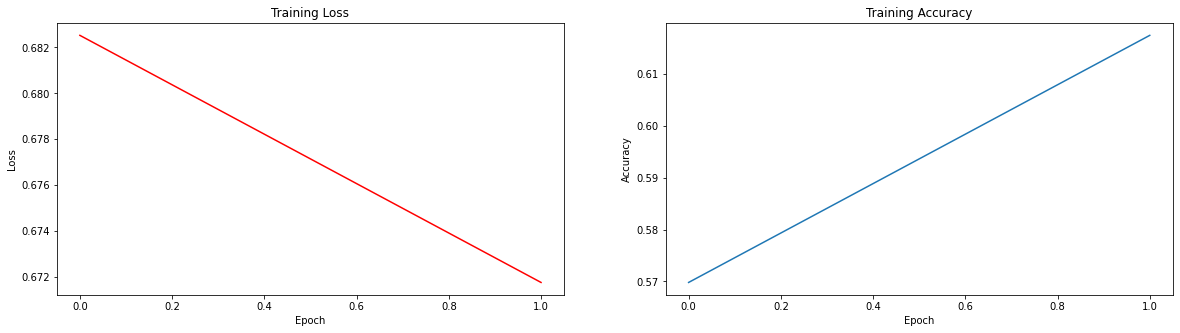

In [9]:
#Plots history of model training
plt.rcParams["figure.figsize"] = (20,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(history.history['accuracy'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training Accuracy')

plt.show()

# Evaluate Model Performance

The model performed very well on training data, but it is likely overfitting. Here we will evaluate the model on test data and see what the model thinks of a review that we write.

In [10]:
#Measures models preformance on the testing data
evaluation = model.evaluate(
    np.array(testing_sequences), #must convert to numpy array before sending to model
    np.array(test_labels),       #must convert to numpy array before sending to model
    batch_size=128,
    verbose=0
)

#Prints accuracy of model on testing data
print("MODEL ACCURACY ON TEST DATA: {}%".format(round(evaluation[1], 3) * 100))

MODEL ACCURACY ON TEST DATA: 60.0%


In [11]:
#Lets see what the model thinks of a new review (keep in mind the review will be cut off after 20 words)
#Enter your review here
NEW_REVIEW =\
"""
This movie was garbage. I wish I never came to the theater to watch it.
"""

In [12]:
#Process the new review the same way the test text was processed
new_review_sequence = tokenizer.texts_to_sequences([NEW_REVIEW])
new_review_sequence = pad_sequences(new_review_sequence, maxlen=20)

# #sends new review to be predicted by the model
new_review_prediction = np.round(model.predict(np.array(new_review_sequence))[0][0])
sentiment = "NEGATIVE" if new_review_prediction == 0 else "POSITIVE"

# #displays what the model thinks the sentiment of the review was
print("MOVIE REVIEW:", NEW_REVIEW)
print("MODEL PREDICTED SENTIMENT:", sentiment)

MOVIE REVIEW: 
This movie was garbage. I wish I never came to the theater to watch it.

MODEL PREDICTED SENTIMENT: NEGATIVE


### Now try and see if you can achieve a better accuracy!


### Similar Notebooks
**TensorFlow Image Classification Guide**: https://www.kaggle.com/code/calebreigada/tensorflow-image-classification-guide

**TensorFlow Time Series Forecasting Guide**:
https://www.kaggle.com/code/calebreigada/tensorflow-time-series-forecasting-guide

In [13]:
# task 4.2: Сделать модель с разным количеством 
#     - слоев, размером словаря 
#     - функции активации
#     - dropout, оптимизатором




# LSTM

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, SimpleRNN
from tensorflow.keras.optimizers import Adam

#input dimensions is equal to number of words tokenized (defined above)
input_dim = 10_000
# input length will be the length of our padded sequences
input_length = 20


#defines a text classifier model
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=64, input_length=input_length),
    Bidirectional(LSTM(150, return_sequences=True)),
    Dropout(0.4),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 64)            640000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20, 300)           258000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 300)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 20, 512)           154112    
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 512)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 20, 1)             513       
Total params: 1,052,625
Trainable params: 1,052,625
Non-trainable params: 0
____________________________________________

In [15]:
#trains the model
history = model.fit(
    np.array(training_sequences), #must convert to numpy array before sending to model
    np.array(train_labels),       #must convert to numpy array before sending to model
    epochs=2, 
    batch_size=32,                
    callbacks=[my_callback, lr_scheduler])

Epoch 1/2
782/782 [==============================] - 9s 7ms/step - loss: 0.6180 - accuracy: 0.6574
Epoch 2/2
782/782 [==============================] - 5s 7ms/step - loss: 0.4794 - accuracy: 0.7758


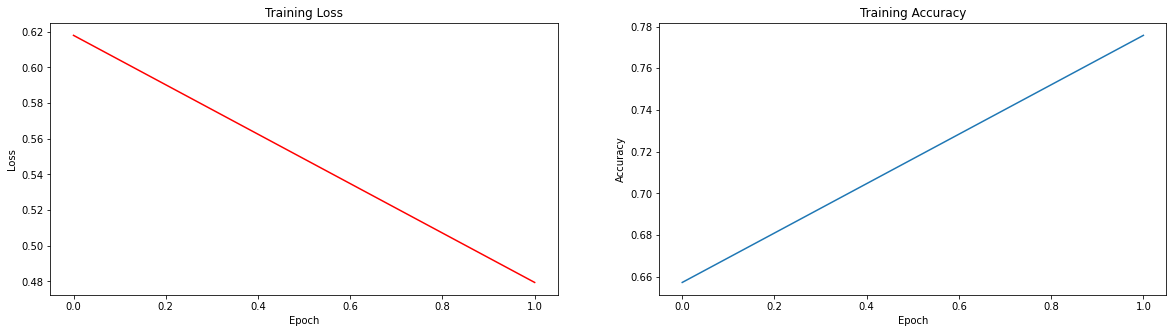

In [16]:
#Plots history of model training
plt.rcParams["figure.figsize"] = (20,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(history.history['accuracy'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training Accuracy')

plt.show()

In [17]:
#Measures models preformance on the testing data
evaluation = model.evaluate(
    np.array(testing_sequences), #must convert to numpy array before sending to model
    np.array(test_labels),       #must convert to numpy array before sending to model
    batch_size=128,
    verbose=0
)

#Prints accuracy of model on testing data
print("MODEL ACCURACY ON TEST DATA: {}%".format(round(evaluation[1], 3) * 100))

MODEL ACCURACY ON TEST DATA: 68.4%


In [18]:
# task4.3. Реализовать модель выше с большим количеством слоев. 
# активации, dropout & etc
# task4.4.Сравнить скорость выполнения с и без GPU

